In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
import os
from PIL import Image
import numpy as np
import torch
# from ensemble_boxes import *
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as T

In [2]:
# dataset
SZ = 256
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1, trans_prob=0)
ds = dm.test_dataloader().dataset
# ds = dm.train_dataloader().dataset

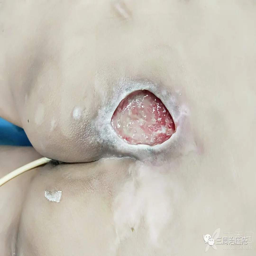

In [247]:
image,target = ds[10]
batch2pil(image).resize((SZ,SZ))

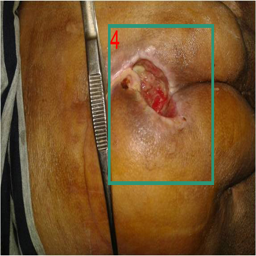

In [245]:
draw_bbox(image, target,th=0.5).resize((SZ,SZ))

CPU times: user 36.3 s, sys: 3.85 s, total: 40.2 s
Wall time: 2.46 s


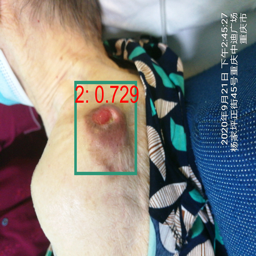

In [211]:
%%time
# 单样本预测
# pred_img = Image.open('data/VOCdevkit/VOC2007/JPEGImages/B01_00003.jpg')
# inp = T.ToTensor()(pred_img)
inp = image
model = MyFasterRCNN.load_from_checkpoint('mlruns/3/8125991a77df4bf9a5499367b41e3970/checkpoints/epoch=59-step=16979.ckpt')
net = model.net
net.eval()
pass
out = net([inp],None)[0]
draw_bbox(inp,out,th=0.5).resize((SZ,SZ))

B04_00203
B04_00115


KeyboardInterrupt: 

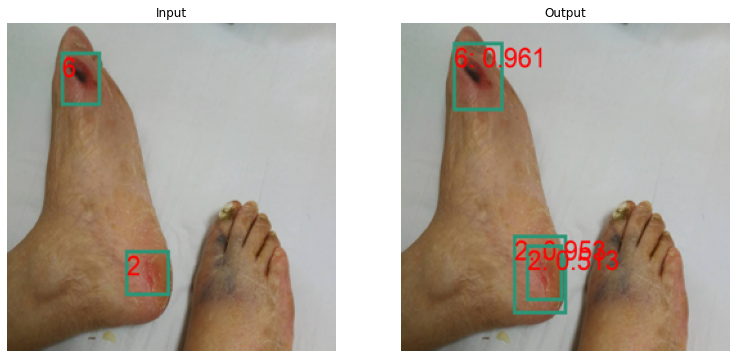

In [15]:
# 批量比较ground-truth 和 pred

for i in range(100):
# input
    idx = i # 22 25 32 49 93 95 97
    SZ = 256
    image,target = ds[idx]
    print(target['fname'])
    # print('gt:',target['labels'])
    im1 = draw_bbox(image,target).resize((SZ,SZ))

    # output
    model = MyFasterRCNN.load_from_checkpoint('mlruns/3/8125991a77df4bf9a5499367b41e3970/checkpoints/epoch=59-step=16979.ckpt')
    net = model.net
    net.eval()
    out = net([image],[target])[0]
    # print('out labels: ', out['labels'])
    # print('out scores: ', out['scores'].detach())
    # print(out['boxes'])
    im2=draw_bbox(image,out,th=0.5).resize((SZ,SZ))


    # SCR: 输入的是一个out，参数score_th=0.5，overlap_th>0.9
    # out = utils.same_class_remove(out)
    # im3 = draw_bbox(image,out,th=0.5).resize((SZ,SZ))


    # plot
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(im1)
    plt.axis('off')
    plt.title('Input')

    plt.subplot(1,3,2)
    plt.imshow(im2)
    plt.axis('off')
    plt.title('Output')



    # plt.subplot(1,3,3)
    # plt.imshow(im3)
    # plt.axis('off')
    # plt.title('SCR')
    # plt.show()
    plt.savefig(f'outputs/{i}.jpg',bbox_inches='tight',pad_inches=0.0)

In [ ]:
for i in range(100):

    # input
    idx = i # 22 25 32 49 93 95 97
    SZ = 256
    image,target = ds[idx]
    print(target['fname'])
    # print('gt:',target['labels'])
    im1 = draw_bbox(image,target).resize((SZ,SZ))


    # output
    model = MyFasterRCNN.load_from_checkpoint('mlruns/3/8125991a77df4bf9a5499367b41e3970/checkpoints/epoch=59-step=16979.ckpt')
    net = model.net
    net.eval()
    out = net([image],[target])[0]
    # print('out labels: ', out['labels'])
    # print('out scores: ', out['scores'].detach())
    # print(out['boxes'])
    im2=draw_bbox(image,out,th=0.5).resize((SZ,SZ))


    # SCR: 输入的是一个out，参数score_th=0.5，overlap_th>0.9
    # out = utils.same_class_remove(out)
    # im3 = draw_bbox(image,out,th=0.5).resize((SZ,SZ))


    # plot
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(im1)
    plt.axis('off')
    plt.title('Input')

    plt.subplot(1,3,2)
    plt.imshow(im2)
    plt.axis('off')
    plt.title('Output')
    
    plt.save('')



# plt.subplot(1,3,3)
# plt.imshow(im3)
# plt.axis('off')
# plt.title('SCR')
# plt.show()

### Batch Eval 计算分数

In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule, BedsoreLMDBDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import voc_eval
import os

detpath = 'temp/det_outs.txt'
imgsetfile = 'temp/evallist.txt'

In [2]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1,trans_prob=0.5)

ds = dm.test_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/3/8125991a77df4bf9a5499367b41e3970/checkpoints/epoch=59-step=16979.ckpt')
net = model.net
net.eval()
pass

In [3]:
# 预测
outs = []
for image,target in tqdm(ds):
    out = net([image],[target])[0]
    outs += out2detfile(target,out)        

100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


In [4]:
# 将检测结果写入文件
os.remove(detpath)
for i in outs:
    with open(detpath,'a+') as f:
        f.write(i)

In [5]:
# 预测文件列表
os.remove(imgsetfile)
for _,target in ds:
    fname= target['fname']
    with open(imgsetfile,'a+') as f:
        f.write(fname +'\n')

In [6]:
voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  '深部组织损伤',
                  ovthresh=0.5,
                  use_07_metric=True)

(array([0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375, 0.4375,
        0.4375, 0.4375, 0.4375]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.875     , 0.77777778, 0.7       ,
        0.63636364]),
 0.4545454545454546)

In [7]:
tissus_name = ['1期','2期','3期','4期','不可分期','深部组织损伤']
mAP = []
for i in tissus_name:
    ap = voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  i,
                  ovthresh=0.5,
                  use_07_metric=True)[-1]
    print(ap)
    mAP.append(ap)
sum(mAP)/len(mAP)

0.5012987012987014
0.7372009569377991
0.4
0.7409943424009919
0.7833917265965948
0.4545454545454546


0.602905196963257

# 单样本测试

In [88]:
image,target = ds[25]
net.eval()
out = net([image],[target])[0]
out = utils.same_class_remove(out)

outs = []
outs += out2detfile(target,out)
# 将检测结果写入文件

os.remove(detpath)
for i in outs:
    with open(detpath,'a+') as f:
        f.write(i)
        
# 预测文件列表
os.remove(imgsetfile)
fname= target['fname']
with open(imgsetfile,'a+') as f:
    f.write(fname +'\n')
    
voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  '深部组织损伤',
                  ovthresh=0.3,
                  use_07_metric=True)

(array([1.]), array([1.]), 1.0000000000000002)